In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
import re
import sys
import pprint
import collections

In [2]:
def fixCharge(biHeavyAtomList):
    # input is list of "ligand class"
    l1 = biHeavyAtomList[0]
    l2 = biHeavyAtomList[1]
    TotalCharge = l1.charge  # because all charge is stored on the first atom
    bestScore = 10
    bestCharges = [TotalCharge, 0]
    bestBondOrder = 0
    for l1Charge in range(-2, 3):
        for l2Charge in range(-2, 3):
            if TotalCharge == l1Charge + l2Charge:

                numVe1 = (l1.numValE + l1.charge -l1Charge) - 2 * l1.numLP - 2 * l1.numberOfHs
                numVe2 = (l2.numValE - l2Charge) - 2 * l2.numLP - 2 * l2.numberOfHs
                
                thisScore = abs(numVe1 - numVe2)
                bondOrder = min(numVe1, numVe2)
                if thisScore <= bestScore and bondOrder < 5 and bondOrder >= 0:
                    bestScore = thisScore
                    bestCharges = [l1Charge, l2Charge]
                    bestBondOrder = bondOrder

    return (bestBondOrder, bestCharges, bestScore)

In [3]:
def fixCharge_bident(biHeavyAtomList):
    # input is list of "ligand class"
    l1 = biHeavyAtomList[0]
    l2 = biHeavyAtomList[1]
    bondScore = 0
    TotalCharge = l1.charge

    bestCharges = [TotalCharge, 0]
    
    bestb12 = 5
    bestb23 = 5
    
    bestCharge1 = 55
    bestCharge2 = 55
    hasSet = False
#     print('l1.numLP: ' + str(l1.numLP)+ ' l2.numLP: ' + str(l2.numLP))
#     print('l1.charge: ' + str(l1.charge))
#     print('l1.numValE: ' + str(l1.numValE)+ ' l2.numValE: ' + str(l2.numValE))
#     print('l1.numberOfHs: ' + str(l1.numberOfHs)+' l2.numberOfHs: ' + str(l2.numberOfHs))
    for l1Charge in range(-2, 3):
        for l2Charge in range(-2, 3):
            if TotalCharge == l1Charge + l2Charge: 

                numVe1 = (l1.numValE + l1.charge - l1Charge) - 2 * l1.numLP - 2 * l1.numberOfHs
                numVe2 = (l2.numValE - l2Charge) - 2 * l2.numLP - 2 * l2.numberOfHs

#                 print('numVe1 = (l1.numValE + l1.charge - l1Charge) - 2 * l1.numLP - 2 * l1.numberOfHs')
#                 print('numVe1: ' + str(numVe1)  +  ' numVe2: ' + str(numVe2))
#                 print('ve1+2: ' + str(numVe1) + " and " + str(numVe2))    
#                 print('l1Charge: ' + str(l1Charge)+ ' l2Charge: ' + str(l2Charge))
#                 print('1: ' + l1.name + 'H' + str(l1.numberOfHs) + ' charge=' + str(l1.charge))
#                 print('2: ' + l2.name + 'H' + str(l2.numberOfHs) + ' charge=' + str(l2.charge))
                
                if numVe1 > 0 and numVe2 > 1:
#                     print('candidate for bonding')
                    b12list = []
                    for bo in range(1,numVe2+1):
                        b12list.append(np.abs(numVe2 - numVe1 - bo))
                    
                    b12 = np.argmin(b12list)+1
                    b23 = np.min([numVe1, (numVe2 - b12)])
                    
#                     if b12 < bestb12 and b23 < bestb23:
                    if (abs(l1Charge)+abs(l2Charge)) < (abs(bestCharge1)+abs(bestCharge2)):
#                         print('best config with b12: ' + str(b12) + ' and  b23: ' +str(b23) )
                        bestb12 = b12
                        bestb23 = b23
                        bestCharge1 = l1Charge
                        bestCharge2 = l2Charge  
                        bondScore = 1
                        if not hasSet:
                            hasSet = True
                    
    if not hasSet:
        bestb12 = 0
        bestb23 = 0
        bestCharge1 = TotalCharge
        bestCharge2 = 0
        
#                 print('======')
    return (bestb12, bestb23, [bestCharge1, bestCharge2], bondScore)

In [4]:
# SC
scSeriesMo = ['[Cl-]', '[OH-]', '[S--]', '[OH2]', '[NH3]',\
               '[PH3]','[SH2]'] #up to NHHH from spectrochemical series, rest heather's excel

scSeriesDi = [
    '[S-]#[S-]', '[C]#4[N-]', '[N-]#4[C]', '[C+]#[O-]', '[N+]=[O]', '[O-]#[O-]']
#               ,\
#              '[C][NH]','[C-][P]','[C][PH]','[C][S]','[N][CH]','[N][P]','[N+][S]',\
#              '[O][C]','[O+][N]','[O+][P]','[O++][P]','[P-][C]','[P][CH]','[P][N]',\
#              '[P+][O]','[P+][S]','[S][C]','[S+][N]','[S++][O]','[S+][P]',\
#              '[O-][OH]','[S-][SH]'] # up to O22- is from wiki, rest from heather's table

classicBidentates = ['[NH2]-[CH2]-[CH2]-[NH2]']

boDict = {
    0: '#0',
    1: '-',
    2: '=',
    3: '#',
    4: '#4',
    5: '#5',
    -1: '#-1',
}

In [5]:
# list of elements with name as key and [total electrons, valence electrons, usually used for bonds] as value
elemList = {
    'C': [6, 4, 4],
    'N': [7, 5, 3],
    'O': [8, 6, 2],
    'P': [15, 5, 3],
    'S': [16, 6, 2]
}  # 'Si':[14,4,4],'Cl':[17,7,1]

components = "CNOPS"
chargeList = range(-2, 3)
# number of H atoms we are sampling through
hList = range(0, 5)


class ligand():
    def __init__(self, name, numberOfHs, charge):
        self.name = name
        self.charge = charge
        self.numberOfHs = numberOfHs
        self.numberOfEs = self.getNumE()
        self.getNumE()

    def print_name(self):
        print(self.name)

    def print_charge(self):
        print(self.charge)

    def print_numberOfHs(self):
        print(self.numberOfHs)

    # CHARGES
    def setCharge(self, charge):
        self.charge = charge
        self.getNumE()

    def incrCharge(self):
        self.charge += 1
        self.getNumE()

    def decrCharge(self):
        self.charge -= 1
        self.getNumE()

    # HYDROGENS
    def setH(self, number):
        self.numberOfHs = number
        self.getNumE()

    def addH(self):
        self.numberOfHs += 1
        self.getNumE()

    def rmH(self):
        self.numberOfHs -= 1
        self.getNumE()

    def getNumE(self):
        self.numLP = int((elemList[self.name][1] - elemList[self.name][2]) / 2)
        self.numValE = elemList[self.name][1]
        self.numE = elemList[self.name][0]
        mod = self.numberOfHs - self.charge
        self.numValE += mod
        self.numE += mod

    def getSmiles(self):
        """Generates a SMILES string. The first row adds hydrogen and the second row charges"""
        # self.SMILES = "[" + self.name + "".join(["H" for i in range(0, self.numberOfHs)])
        # this is for SMILES with HHH instead of H3 etc.
        if self.numberOfHs > 1:
            self.SMILES = "[" + self.name + "H" + str(self.numberOfHs)
        elif self.numberOfHs == 1:
            self.SMILES = "[" + self.name + "H"
        else:
            self.SMILES = "[" + self.name
        self.SMILES += "".join([
            "+" if self.charge > 0 else "-"
            for i in range(0, abs(int(self.charge)))
        ]) + "]"

    def testOctetRule(self):
        """Test whether a mono-heavy-atom ligand fulfills the octet rule. Results < 8 means that there are 
        too many electrons, result > 8 means that there are not enough electrons."""
        result = 8 - self.numValE
        return (result)

    def testValenceShell(self):
        """Since open shell complexes are difficult to converge in DFT, we restrict ourselves to closed shell ones."""
        result = int(not self.numValE % 2)
        return (result)

    def score(self):
        """The health score helps to prune the full enumeration by setting open shell ligands to zero and 
        weights ligands with negative charge more than ligands with positive charge. Greater is better in this
        score."""
        #         score = (10-(-1*self.testOctetRule() if self.testOctetRule() < 0 else 0.5*self.testOctetRule())) #*self.testValenceShell() # removed the testValshell bc it is only relevant for the whole ligand
        score = 4 - np.abs(int(self.testOctetRule()))
        return (score)

Name: Charge + octet + CA = Score
[NH3]: 3 + 4 + 3 = 10
[OH-]: 3 + 4 + 3 = 10
[OH2]: 3 + 4 + 3 = 10
[PH3]: 3 + 4 + 3 = 10
[S--]: 3 + 4 + 3 = 10
[SH2]: 3 + 4 + 3 = 10
All monoatoms: 125
All scored monoatoms: 50
All wished for monoatoms (>7): 29


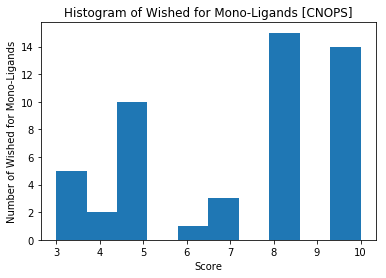

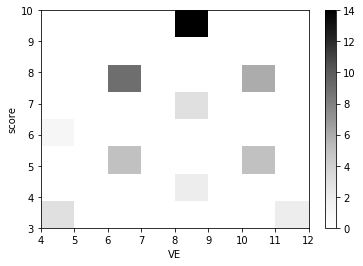

In [7]:
# generate exhaustive output list for mono-ligands
dictMo = {}
scoredDictMo = {}
wishedDictMo = {}

for elem in elemList.keys():
    for charge in chargeList:
        l = ligand(elem, 0, 0)
        l.setCharge(charge)
        for h in hList:
            if h:
                l.addH()
            l.getSmiles()
            dictMo[l.SMILES] = [l.numE,l.numValE,l.numLP,l.charge,l.numberOfHs,\
                                l.testOctetRule(),l.testValenceShell(),l.score()]
            
for name, line in dictMo.items():
    octetScore = line[7]
    charge = line[3]
    numberOfHs = line[4]
    numValE = line[1]
    closedShell = int(not((numValE)%2))
    # Charge: +1 >= charge >= -3
    # Sterics: 4 >= Number of H at Coordinating Atom (CA)
    # Closed Shell only
    if 1 >= charge and charge >= -3 and 4 >= numberOfHs and closedShell == 1: 
        
        # Charge score
        if charge == 1:
            scoreCharge = 0
        if charge <= 0 and charge >= -2:
            scoreCharge = 3
        elif charge == -3:
            scoreCharge = 0

        # CA Sterics Score
        if numberOfHs == 4:
            scoreCa = 0 
        else:
            scoreCa = 3
    
        # Total score
        score = scoreCharge + octetScore + scoreCa
        
        # Dict with only scored ligands
        dictMo[name] = line + [scoreCharge] + [octetScore] + [scoreCa] + [score] 
        scoredDictMo[name] = line + [scoreCharge] + [octetScore] + [scoreCa] + [score] 
        
    else:
        score = 0.0
        dictMo[name] = line + [0] + [0] + [0] + [score]

print("Name: Charge + octet + CA = Score")



histCharge = list() # lists of charge, octet difference, occupancy of CA and score to see histograms
histOctet = list()
histCa = list()
histScore = list()
histVE = list()
thresholdMo = 7 # define threshold for wishedDictMo
for name, props in scoredDictMo.items():        
    histCharge.append(props[-4])
    histOctet.append(props[-3])
    histCa.append(props[-2])
    histScore.append(props[-1])
    histVE.append(props[1])
    
    # Populate the wishedDictMo
    if props[-1] > thresholdMo: 
        wishedDictMo[name] = props
    
    # Evaluate compounds from Spectrochemical Series
    for i in range(0, len(scSeriesMo)):
        if name == scSeriesMo[i]:
            print(name + ': ' +str(props[-4])+" + "+str(props[-3])+" + "+str(props[-2])+' = '+str(props[-1])) 

print('======')
print("All monoatoms: " + str(len(dictMo)))  
print("All scored monoatoms: " + str(len(scoredDictMo)))
print("All wished for monoatoms (>" + str(thresholdMo) + "): " + str(len(wishedDictMo)))
print('======')

plt.xlabel('Score')
plt.ylabel('Number of Wished for Mono-Ligands')
# plt.yscale('log', nonposy='clip')
plt.title('Histogram of Wished for Mono-Ligands ['+ components + "]")
plt.hist(histScore)
# plt.savefig('monoDistr' + components + ".pdf", bbox_inches='tight')
plt.show()


plt.hist2d(histVE, histScore, bins=8, cmap = 'Greys')
plt.xlabel('VE')
plt.ylabel('score')
plt.colorbar()
plt.show()

# pprint.pprint(re.sub('[\'()a-z_]',"",str(wishedDictMo.keys())))




In [8]:
# selection of monos
print('These are the ' + str(len(wishedDictMo)) + ' structure we wish for:')
pprint.pprint(wishedDictMo)
veMo = {'sixVeMo': 0, 'eightVeMo': 0, 'tenVeMo': 0, 'elseVeMo': 0, 'elseVeMo': 0}
smVeMo = {'smSixVeMo': [], 'smEightVeMo': [], 'smTenVeMo': [], 'smElseVeMo': [], 'smElseVeMo': []}
for name, props in wishedDictMo.items():
    if props[1] == 6:
        veMo['sixVeMo'] += 1
        smVeMo["smSixVeMo"].append(name)
    elif props[1] == 8:
        veMo['eightVeMo'] += 1
        smVeMo["smEightVeMo"].append(name)
    elif props[1] == 10:
        veMo['tenVeMo'] += 1
        smVeMo["smTenVeMo"].append(name)
    else:
        veMo['elseVeMo'] += 1
        smVeMo["smElseVeMo"].append(name)

print('\n Their distribution for 6, 8, and 10 VE: ')
print(veMo)
print('\n Their SMILES: ')
pprint.pprint(smVeMo)
print('\n')

selListMo = list()
rnSixVe = random.sample(range(0, len(smVeMo["smSixVeMo"])), 6)
for i in range(0, len(rnSixVe)):
    selListMo.append(smVeMo["smSixVeMo"][rnSixVe[i]])
    
rnEightVe = random.sample(range(0, len(smVeMo["smEightVeMo"])), 10)
for i in range(0, len(rnEightVe)):
    selListMo.append(smVeMo["smEightVeMo"][rnEightVe[i]])
    
rnTenVe = random.sample(range(0, len(smVeMo["smTenVeMo"])), 4)
for i in range(0, len(rnTenVe)):
    selListMo.append(smVeMo["smTenVeMo"][rnTenVe[i]])

print('\n A random sample of these structures (2/3 of each isoelectronic group): ')
pprint.pprint(selListMo)   
print('A total of ' + str(len(selListMo)) + ' Structures.')

These are the 29 structure we wish for:
{'[C--]': [8, 6, 0, -2, 0, 2, 1, 2, 3, 2, 3, 8],
 '[CH-]': [8, 6, 0, -1, 1, 2, 1, 2, 3, 2, 3, 8],
 '[CH2--]': [10, 8, 0, -2, 2, 0, 1, 4, 3, 4, 3, 10],
 '[CH2]': [8, 6, 0, 0, 2, 2, 1, 2, 3, 2, 3, 8],
 '[CH3-]': [10, 8, 0, -1, 3, 0, 1, 4, 3, 4, 3, 10],
 '[N-]': [8, 6, 1, -1, 0, 2, 1, 2, 3, 2, 3, 8],
 '[NH--]': [10, 8, 1, -2, 1, 0, 1, 4, 3, 4, 3, 10],
 '[NH2-]': [10, 8, 1, -1, 2, 0, 1, 4, 3, 4, 3, 10],
 '[NH3--]': [12, 10, 1, -2, 3, -2, 1, 2, 3, 2, 3, 8],
 '[NH3]': [10, 8, 1, 0, 3, 0, 1, 4, 3, 4, 3, 10],
 '[NH]': [8, 6, 1, 0, 1, 2, 1, 2, 3, 2, 3, 8],
 '[O--]': [10, 8, 2, -2, 0, 0, 1, 4, 3, 4, 3, 10],
 '[OH-]': [10, 8, 2, -1, 1, 0, 1, 4, 3, 4, 3, 10],
 '[OH2--]': [12, 10, 2, -2, 2, -2, 1, 2, 3, 2, 3, 8],
 '[OH2]': [10, 8, 2, 0, 2, 0, 1, 4, 3, 4, 3, 10],
 '[OH3-]': [12, 10, 2, -1, 3, -2, 1, 2, 3, 2, 3, 8],
 '[O]': [8, 6, 2, 0, 0, 2, 1, 2, 3, 2, 3, 8],
 '[P-]': [16, 6, 1, -1, 0, 2, 1, 2, 3, 2, 3, 8],
 '[PH--]': [18, 8, 1, -2, 1, 0, 1, 4, 3, 4, 3, 10],


Name, Score = Charge + VSEPR + CA
[C]#4[N-]: 3 + 4 + 3 = 10
[C+]#[O-]: 3 + 4 + 3 = 10
[N-]#4[C]: 3 + 5 + 3 = 11
[N+]=[O]: 0 + 5 + 3 = 8
[O-]#[O-]: 3 + 4 + 3 = 10
[S-]#[S-]: 3 + 4 + 3 = 10
All diatoms: 5625
All scored diatoms: 1500
All wished for diatoms (>9): 374


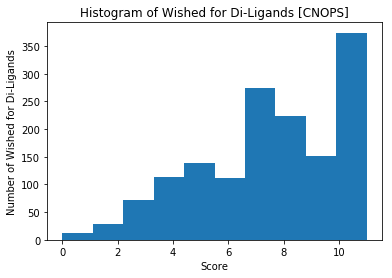

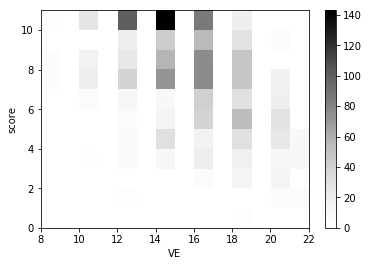

{'[C+]#[CH2-]': [5, 3, 0, 1, 0, 5, 0, -1, 9, 7, 0, -1, 2, 1, 0, 3, 3, 4, 3, 10],
 '[C+]#[NH-]': [5, 3, 0, 1, 0, 5, 0, -1, 9, 7, 1, -1, 1, 1, 0, 3, 3, 4, 3, 10],
 '[C+]#[O-]': [5, 3, 0, 1, 0, 5, 0, -1, 9, 7, 2, -1, 0, 1, 0, 3, 3, 4, 3, 10],
 '[C+]#[PH-]': [5, 3, 0, 1, 0, 5, 0, -1, 17, 7, 1, -1, 1, 1, 0, 3, 3, 4, 3, 10],
 '[C+]#[S-]': [5, 3, 0, 1, 0, 5, 0, -1, 17, 7, 2, -1, 0, 1, 0, 3, 3, 4, 3, 10],
 '[CH+]=[CH3-]': [6,
                  4,
                  0,
                  1,
                  1,
                  4,
                  1,
                  0,
                  10,
                  8,
                  0,
                  -1,
                  3,
                  0,
                  1,
                  4,
                  3,
                  4,
                  3,
                  10],
 '[CH+]=[NH2-]': [6,
                  4,
                  0,
                  1,
                  1,
                  4,
                  1,
                  0,
       

                2,
                3,
                4,
                3,
                10],
 '[PH+]-[CH4-]': [15,
                  5,
                  1,
                  1,
                  1,
                  3,
                  0,
                  1,
                  11,
                  9,
                  0,
                  -1,
                  4,
                  -1,
                  0,
                  3,
                  3,
                  4,
                  3,
                  10],
 '[PH+]-[NH3-]': [15,
                  5,
                  1,
                  1,
                  1,
                  3,
                  0,
                  1,
                  11,
                  9,
                  1,
                  -1,
                  3,
                  -1,
                  0,
                  3,
                  3,
                  4,
                  3,
                  10],
 '[PH+]-[OH2-]': [15,
                  5,
        

In [35]:
# generate exhaustive output list for di-ligands
dictDi = {}
scoredDictDi = {}
wishedDictDi = {}

for elem1 in elemList.keys():
    for elem2 in elemList.keys():
        for charge1 in range(
                -4, 5
        ):  # charge1 on one but from -4 to +4, because charge is not localized in dft
            for h1 in hList:
                for h2 in hList:
                    l1 = ligand(elem1, 0, 0)
                    l1.setCharge(charge1)
                    l1.setH(h1)
                    l2 = ligand(elem2, 0, 0)
                    l2.setCharge(0)  # charge should distribute from first atom
                    l2.setH(h2)
                    bestBondOrder, bestCharges, bestScore = fixCharge([l1, l2])
                    l1.setCharge(bestCharges[0])
                    l2.setCharge(bestCharges[1])
                    l1.getSmiles()
                    l2.getSmiles()
                    diatomName = ''.join(
                        l1.SMILES + boDict[bestBondOrder] + l2.SMILES)
                    dictDi[diatomName] = [l1.numE, l1.numValE, l1.numLP, l1.charge, l1.numberOfHs, \
                                         l1.testOctetRule(), l1.testValenceShell(), l1.score(),\
                                         l2.numE, l2.numValE, l2.numLP, l2.charge, l2.numberOfHs, \
                                         l2.testOctetRule(), l2.testValenceShell(), l2.score()]

for name, line in dictDi.items():
    charge = line[3] + line[11]
    numberOfHs = line[4]
    numValE1 = line[1]
    numValE2 = line[9]
    numLP1 = line[2]
    numLP2 = line[10]
    closedShell = int(not ((numValE1 + numValE2) % 2))
    # Charge: 1 >= charge >= -4
    # Sterics: 4 >= Number of H at CA
    # Closed Shell only
    if charge <= 1 and numberOfHs < 4 and closedShell == 1:  # overall charge should not exceed +1 and not more than 3 H at CA

        # Charge score
        if charge == 1:
            scoreCharge = 0
        if charge <= 0 and charge >= -2:
            scoreCharge = 3
        elif charge == -3:
            scoreCharge = 1
        elif charge == -4:
            scoreCharge = 0

        # VSEPR score
        usual1 = numValE1 - 2 * numLP1 + charge * 0 - 2 * numberOfHs
        usual2 = numValE2 - 2 * numLP2 + line[11] - 2 * line[12]
        scoreVsepr = 5 - np.abs(usual1 - usual2)

        # CA Sterics Score
        if line[4] == 3:
            scoreCa = 0
        else:
            scoreCa = 3

        #Total score
        score = scoreCharge + scoreVsepr + scoreCa

        # Dict with only scored ligands
        dictDi[name] = line + [scoreCharge] + [scoreVsepr] + [scoreCa
                                                              ] + [score]
        scoredDictDi[name] = line + [scoreCharge] + [scoreVsepr
                                                     ] + [scoreCa] + [score]

    else:
        score = 0.0
        dictDi[name] = line + [0] + [0] + [0] + [score]

print("Name, Score = Charge + VSEPR + CA")

histCharge = list()
histVsepr = list()
histCa = list()
histScore = list()
histVE = list()
thresholdDi = 9

for name, props in scoredDictDi.items():
    histCharge.append(props[-4])
    histVsepr.append(props[-3])
    histCa.append(props[-2])
    histScore.append(props[-1])
    histVE.append(props[1] + props[9])

    # populate the wishedDictDi
    if props[-1] > 9:
        wishedDictDi[name] = props

    # Evaluate compounds from Spectrochemical Series
    for i in range(0, len(scSeriesDi)):
        if name == scSeriesDi[i]:
            print(name + ': ' + str(props[-4]) + " + " + str(props[-3]) +
                  " + " + str(props[-2]) + ' = ' + str(props[-1]))

print('======')
print("All diatoms: " + str(len(dictDi)))
print("All scored diatoms: " + str(len(scoredDictDi)))
print("All wished for diatoms (>" + str(thresholdDi) + "): " +
      str(len(wishedDictDi)))
print('======')

plt.xlabel('Score')
plt.ylabel('Number of Wished for Di-Ligands')
# plt.yscale('log', nonposy='clip')
plt.title('Histogram of Wished for Di-Ligands [' + components + "]")
plt.hist(histScore)
plt.savefig('distrDi' + components + ".pdf", bbox_inches='tight')
plt.show()

plt.hist2d(histVE, histScore, bins=[range(8, 23), range(0, 12)], cmap = 'Greys')
plt.xlabel('VE')
plt.ylabel('score')
# plt.ylim((0,10))
# plt.xlim((8,22))
plt.colorbar()
plt.show()

# pprint.pprint(re.sub('[\'()a-z_]',"",str(wishedDictDi.keys())))
pprint.pprint(wishedDictDi)

In [12]:
# selection of di ligands
print('These are the ' + str(len(wishedDictDi)) + ' structure we wish for:')
# pprint.pprint(wishedDictDi)
veDi = {'VeDi8': 0, 'VeDi10': 0, 'VeDi12': 0, 'VeDi14': 0, 'VeDi16': 0, 'VeDi18': 0}
smVeDi = {'smVeDi8': [], 'smVeDi10': [], 'smVeDi12': [], 'smVeDi14': [], 'smVeDi16': [], 'smVeDi18': []}
for name, props in wishedDictDi.items():
    if props[1] + props[9] == 8:
        veDi['VeDi8'] += 1
        smVeDi["smVeDi8"].append(name)
    elif props[1] + props[9] == 10:
        veDi['VeDi10'] += 1
        smVeDi["smVeDi10"].append(name)
    elif props[1] + props[9] == 12:
        veDi['VeDi12'] += 1
        smVeDi["smVeDi12"].append(name)
    elif props[1] + props[9] == 14:
        veDi['VeDi14'] += 1
        smVeDi["smVeDi14"].append(name)
    elif props[1] + props[9] == 16:
        veDi['VeDi16'] += 1
        smVeDi["smVeDi16"].append(name)
    elif props[1] + props[9] == 18:
        veDi['VeDi18'] += 1
        smVeDi["smVeDi18"].append(name)

print('\n Their distribution for Isoelectronics [8,18]: ')
print(veDi)
print('\n Their SMILES: ')
# pprint.pprint(smVeDi)
print('\n')

selListDi = list()
rn8Ve = random.sample(range(0, len(smVeDi["smVeDi8"])), 1)
for i in range(0, len(rn8Ve)):
    selListDi.append(smVeDi["smVeDi8"][rn8Ve[i]])
    
rn10Ve = random.sample(range(0, len(smVeDi["smVeDi10"])), 5)
for i in range(0, len(rn10Ve)):
    selListDi.append(smVeDi["smVeDi10"][rn10Ve[i]])

rn12Ve = random.sample(range(0, len(smVeDi["smVeDi12"])), 20)
for i in range(0, len(rn12Ve)):
    selListDi.append(smVeDi["smVeDi12"][rn12Ve[i]])

rn14Ve = random.sample(range(0, len(smVeDi["smVeDi14"])), 30)
for i in range(0, len(rn14Ve)):
    selListDi.append(smVeDi["smVeDi14"][rn14Ve[i]])

rn16Ve = random.sample(range(0, len(smVeDi["smVeDi16"])), 20)
for i in range(0, len(rn16Ve)):
    selListDi.append(smVeDi["smVeDi16"][rn16Ve[i]])

rn18Ve = random.sample(range(0, len(smVeDi["smVeDi18"])), 4)
for i in range(0, len(rn18Ve)):
    selListDi.append(smVeDi["smVeDi18"][rn18Ve[i]])


print('\n A random sample of these structures (1/5 of each isoelectronic group): ')
print(selListDi)   
print('A total of ' + str(len(selListDi)) + ' Structures.')

These are the 374 structure we wish for:

 Their distribution for Isoelectronics [8,18]: 
{'VeDi8': 1, 'VeDi10': 26, 'VeDi12': 100, 'VeDi14': 143, 'VeDi16': 86, 'VeDi18': 18}

 Their SMILES: 



 A random sample of these structures (1/5 of each isoelectronic group): 
['[C]#4[C]', '[C+]#[O-]', '[C+]#[CH2-]', '[C]#4[CH-]', '[CH]#[P]', '[C]#4[C--]', '[S]=[NH]', '[P+]=[SH-]', '[CH-]#4[N-]', '[PH]=[PH]', '[PH-]#[CH]', '[SH-]=[CH+]', '[N+]=[OH-]', '[CH]#[CH2-]', '[OH-]=[N+]', '[NH2-]=[P+]', '[P]#[S-]', '[CH+]=[OH-]', '[NH2--]#[C+]', '[P+]=[PH2-]', '[CH]#[O-]', '[NH]=[PH]', '[CH]#[NH-]', '[OH-]=[CH+]', '[N+]=[CH3-]', '[S]=[O]', '[PH2]-[OH]', '[NH2]-[SH]', '[NH+]-[OH2-]', '[NH2--]#[N]', '[S]=[CH3-]', '[OH-]=[S]', '[PH2--]#[P]', '[PH-]#[O-]', '[OH2-]-[CH2+]', '[S-]#[O-]', '[PH2--]#[N]', '[SH]-[CH3]', '[NH]=[OH-]', '[SH-]=[S]', '[PH2]-[CH3]', '[CH2]=[NH2-]', '[O-]#[O-]', '[CH2+]-[CH4-]', '[O+]-[SH2-]', '[O+]-[NH3-]', '[OH--]#[N]', '[NH-]#[NH-]', '[S-]#[PH-]', '[NH2-]=[NH]', '[OH]-[PH2]', '[S-]#[

The 1st [.] is always the CA and the 2nd [.] is the bridging atom:

[NH2]-[CH2]-[CH2]-[NH2]
[9, 7, 1, 0, 2, 1, 0, 3, 8, 6, 0, 0, 2, 1, 1, 1, 2, 1, 2, 3, 3, 3, 5, 14]
5

All bidentates: 625
All scored bidentates: 201
All wished for bidentates: 60


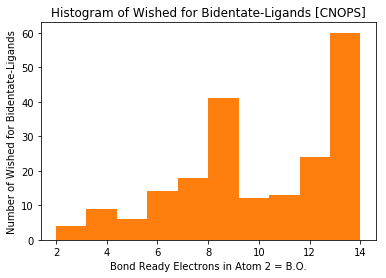

dict_keys(['[CH2]-[CH]=[CH]-[CH2]', '[CH2]-[CH2]-[CH2]-[CH2]', '[CH2]-[N]=[N]-[CH2]', '[CH2]-[NH]-[NH]-[CH2]', '[CH2]-[O]-[O]-[CH2]', '[CH2]-[P]=[P]-[CH2]', '[CH2]-[PH]-[PH]-[CH2]', '[CH2]-[S]-[S]-[CH2]', '[NH]-[CH]=[CH]-[NH]', '[NH]-[CH2]-[CH2]-[NH]', '[NH2]-[CH2]-[CH2]-[NH2]', '[NH]-[N]=[N]-[NH]', '[NH]-[NH]-[NH]-[NH]', '[NH2]-[NH]-[NH]-[NH2]', '[NH]-[O]-[O]-[NH]', '[NH2]-[O]-[O]-[NH2]', '[NH]-[P]=[P]-[NH]', '[NH]-[PH]-[PH]-[NH]', '[NH2]-[PH]-[PH]-[NH2]', '[NH]-[S]-[S]-[NH]', '[NH2]-[S]-[S]-[NH2]', '[O]-[CH]=[CH]-[O]', '[O]-[CH2]-[CH2]-[O]', '[OH]-[CH2]-[CH2]-[OH]', '[O]-[N]=[N]-[O]', '[O]-[NH]-[NH]-[O]', '[OH]-[NH]-[NH]-[OH]', '[O]-[O]-[O]-[O]', '[OH]-[O]-[O]-[OH]', '[O]-[P]=[P]-[O]', '[O]-[PH]-[PH]-[O]', '[OH]-[PH]-[PH]-[OH]', '[O]-[S]-[S]-[O]', '[OH]-[S]-[S]-[OH]', '[PH]-[CH]=[CH]-[PH]', '[PH]-[CH2]-[CH2]-[PH]', '[PH2]-[CH2]-[CH2]-[PH2]', '[PH]-[N]=[N]-[PH]', '[PH]-[NH]-[NH]-[PH]', '[PH2]-[NH]-[NH]-[PH2]', '[PH]-[O]-[O]-[PH]', '[PH2]-[O]-[O]-[PH2]', '[PH]-[P]=[P]-[PH]', '[PH]-[PH]

In [23]:
# enumeration of all homo-bidentates
usual = list()
dictBident = dict()
scoredDictBident = dict()
wishedDictBident = dict()

for elem1 in elemList.keys():
    for elem2 in elemList.keys():
        for charge1 in range(0, 1):
            for h1 in hList:
                for h2 in hList:
#                      if h1 ==2 and h2 ==2 and elem1 == "N" and elem2 == "C":
                        l1 = ligand(elem1, 0, 0)
                        l1.setCharge(charge1)
                        l1.setH(h1)
                        l2 = ligand(elem2, 0, 0)
                        l2.setCharge(0)
                        l2.setH(h2)
                        bestBondOrder1, bestBondOrder2, bestCharges, bondScore = fixCharge_bident([l1, l2])
#                         print(bestBondOrder1)
                        l1.setCharge(bestCharges[0])
                        l2.setCharge(bestCharges[1])
                        l1.getSmiles()
                        l2.getSmiles()
                        diatomName = ''.join(
                            l1.SMILES + boDict[bestBondOrder1] + l2.SMILES +
                            boDict[bestBondOrder2] + l2.SMILES +
                            boDict[bestBondOrder1] + l1.SMILES)
                        
                        dictBident[diatomName] = [
                            l1.numE, l1.numValE, l1.numLP, l1.charge,
                            l1.numberOfHs,
                            l1.testOctetRule(),
                            l1.testValenceShell(),
                            l1.score(), l2.numE, l2.numValE, l2.numLP, l2.charge,
                            l2.numberOfHs,
                            bondScore,
                            bestBondOrder1,
                            bestBondOrder2,
                            l2.testOctetRule(),
                            l2.testValenceShell(),
                            l2.score()
                        ]

# Figure out how many usuals there are in the nonCAs: {-2,4}.
histUsual = list()
for name, props in dictBident.items():
    charge1 = props[3]
    charge2 = props[11]
    charge = charge1 + charge2
    numberOfHs1 = props[4]
    numberOfHs2 = props[12]
    numValE1 = props[1]
    numValE2 = props[9]
    numLP1 = props[2]
    numLP2 = props[10]
    bondScore = props[13]
    bestBondOrder1 = props[14]
    bestBondOrder2 = props[15]
    
    if charge < 3 and charge >= -4 and bondScore == 1 and not(bestBondOrder1 >= 2 and bestBondOrder2 >= 2) and not(bestBondOrder1 == 3 or bestBondOrder2 == 3) :
    # charge under 3 and above -4 (actually, they are all in [-2,0])
    # No ##, =#, #=, ==
    # No #-, -#
        
        # Bond score
        if bestBondOrder1 == 1 and bestBondOrder2 == 1:
            scoreBond = 3
        elif bestBondOrder1 == 1 and bestBondOrder2 == 2:
            scoreBond = 3
        elif bestBondOrder1 == 2 and bestBondOrder2 == 1:
            scoreBond = 0
        
        # fulfill octet
        
        usual1 = numValE1 - 2 * numLP1 + charge1 - 2 * numberOfHs1
        usual2 = numValE2 - 2 * numLP2 + charge2 - 2 * numberOfHs2 - bestBondOrder2
        scoreVsepr = 5 - np.abs(usual1 - usual2)
        
        # Charge score
        # other charges dont happen
        if np.abs(charge1 - charge2) == 2:
            scoreChargeDiff = 0
        elif np.abs(charge1 - charge2) == 0:
            scoreChargeDiff = 3
    
        # CA Sterics Score
        if numberOfHs1 == 3 or numberOfHs2 == 3: # 'and' never happens
            scoreCa = 0
        else:
            scoreCa = 3

        #Total score
        score = scoreChargeDiff + scoreCa + scoreBond + scoreVsepr

        scoredDictBident[name] = props + [scoreChargeDiff] + [scoreCa] + [scoreBond] + [scoreVsepr] + [score]
       
    
thresholdBi = 0
histScore = list()
histCa = list()
histCharge = list()
histVE = list()
histBond = list()
histBondScore = list()
print("The 1st [.] is always the CA and the 2nd [.] is the bridging atom:\n")

for name, props in scoredDictBident.items():
    histScore.append(props[-1])
    histBond.append(props[-2])
    histCa.append(props[-3])
    histCharge.append(props[-4])
    histVE.append(2 * (props[1] + props[9]))
    histBondScore.append(props[13])

    # Populate the wishedDictBident
    if props[-1] > 12:
        wishedDictBident[name] = props

    # Evaluate compounds from Spectrochemical Series
    for i in range(0, len(classicBidentates)):
        if name == classicBidentates[i]:
            print(name)
            print(props)
            usual1 = numValE1 - 2 * numLP1 + charge1 - 2 * numberOfHs1
            usual2 = numValE2 - 2 * numLP2 + charge2 - 2 * numberOfHs2
            print(5 - np.abs(usual1 - usual2))

print('\n======')
print("All bidentates: " + str(len(dictBident)))
print("All scored bidentates: " + str(len(scoredDictBident)))
print("All wished for bidentates: " + str(len(wishedDictBident)))
print('======')

plt.xlabel('Bond Ready Electrons in Atom 2 = B.O.')
plt.ylabel('Number of Wished for Bidentate-Ligands')
# plt.yscale('log', nonposy='clip')
plt.title('Histogram of Wished for Bidentate-Ligands [' + components + "]")
plt.hist(histScore)
# plt.savefig('bidDistr' + components + ".pdf")
plt.show()

# plt.hist(histVE)
# plt.hist2d(histBondScore, histScore)
# plt.xlabel('VE')
# plt.xlabel('BondScore')
# plt.ylabel('Score')
# plt.ylabel('Single or Double or Triple')
# plt.colorbar()
# plt.show()

# plt.xlabel('Number of Bond Ready Electrons on Atom 2')
# plt.ylabel('#')
# plt.hist(histUsual, bins = 14)
# plt.show()
# 
print(wishedDictBident.keys())
plt.hist(histScore)

totC  = 0
totBO = 0
for vals in wishedDictBident.values():
    totC += abs(vals[3])+abs(vals[11])
    totBO += vals[14] + vals[15]
print(totC)
print(totBO)

In [24]:
# selection
print('These are the ' + str(len(wishedDictBident)) + ' structure we wish for:')
# pprint.pprint(wishedDictMo)
veMo = {'sixVeMo': 0, 'eightVeMo': 0, 'tenVeMo': 0, 'elseVeMo': 0, 'elseVeMo': 0}
smVeMo = {'smSixVeMo': [], 'smEightVeMo': [], 'smTenVeMo': [], 'smElseVeMo': [], 'smElseVeMo': []}
for name, props in wishedDictBident.items():
    if props[1] == 6:
        veMo['sixVeMo'] += 1
        smVeMo["smSixVeMo"].append(name)
    elif props[1] == 8:
        veMo['eightVeMo'] += 1
        smVeMo["smEightVeMo"].append(name)
    elif props[1] == 10:
        veMo['tenVeMo'] += 1
        smVeMo["smTenVeMo"].append(name)
    else:
        veMo['elseVeMo'] += 1
        smVeMo["smElseVeMo"].append(name)

print('\n Their distribution for 6, 8, and 10 VE: ')
print(veMo)
print('\n Their SMILES: ')
pprint.pprint(smVeMo)
print('\n')

selListMo = list()
rnSixVe = random.sample(range(0, len(smVeMo["smSixVeMo"])), 6)
for i in range(0, len(rnSixVe)):
    selListMo.append(smVeMo["smSixVeMo"][rnSixVe[i]])
    
rnEightVe = random.sample(range(0, len(smVeMo["smEightVeMo"])), 10)
for i in range(0, len(rnEightVe)):
    selListMo.append(smVeMo["smEightVeMo"][rnEightVe[i]])
    
rnTenVe = random.sample(range(0, len(smVeMo["smTenVeMo"])), 4)
for i in range(0, len(rnTenVe)):
    selListMo.append(smVeMo["smTenVeMo"][rnTenVe[i]])

print('\n A random sample of these structures (2/3 of each isoelectronic group): ')
pprint.pprint(selListMo)   
print('A total of ' + str(len(selListMo)) + ' Structures.')

These are the 60 structure we wish for:

 Their distribution for 6, 8, and 10 VE: 
{'sixVeMo': 40, 'eightVeMo': 0, 'tenVeMo': 0, 'elseVeMo': 20}

 Their SMILES: 
{'smEightVeMo': [],
 'smElseVeMo': ['[NH2]-[CH2]-[CH2]-[NH2]',
                '[NH2]-[NH]-[NH]-[NH2]',
                '[NH2]-[O]-[O]-[NH2]',
                '[NH2]-[PH]-[PH]-[NH2]',
                '[NH2]-[S]-[S]-[NH2]',
                '[OH]-[CH2]-[CH2]-[OH]',
                '[OH]-[NH]-[NH]-[OH]',
                '[OH]-[O]-[O]-[OH]',
                '[OH]-[PH]-[PH]-[OH]',
                '[OH]-[S]-[S]-[OH]',
                '[PH2]-[CH2]-[CH2]-[PH2]',
                '[PH2]-[NH]-[NH]-[PH2]',
                '[PH2]-[O]-[O]-[PH2]',
                '[PH2]-[PH]-[PH]-[PH2]',
                '[PH2]-[S]-[S]-[PH2]',
                '[SH]-[CH2]-[CH2]-[SH]',
                '[SH]-[NH]-[NH]-[SH]',
                '[SH]-[O]-[O]-[SH]',
                '[SH]-[PH]-[PH]-[SH]',
                '[SH]-[S]-[S]-[SH]'],
 'smSixVeMo': ['[CH2]-[CH

ValueError: Sample larger than population or is negative

In [755]:
import collections

gdb4 = "CNOCCCNCOCCCOCCCCCNCCONCOCCCCCOCOCCCCCCOCCOCCCONNCONCCCCCCCOCCCCCCCNNCCNOCCCOCCNOCCOCCCCCCCCCCCNNCCNOCCCOCCNCCCOCNCOCOCOOCCOCCCCCCCOCCOCOCCOCCCCCCCOCNCCOCCCCCCCCCOC"
c_gdb4 = collections.Counter(gdb4)
print(sorted(c_gdb4.items(), key=lambda c_gdb4: c_gdb4[0]))
print(gdb4)
print("\n")

slu1 = str()
# validDictMo can be CNO only if i just regex out the HSP ones. In diatoms I need to reassemble.
for name, prop in validDictMo.items():
    slu1 += re.sub('[\]\[\+\-HSP]','',name)
print(''.join(slu1))
c_slu1 = collections.Counter(slu1)
print(sorted(c_slu1.items(), key=lambda c_slu1: c_slu1[0]))
print("\n")

slu2 = str()
for name, prop in validDictDi.items():
    if 'P' in name or 'S' in name:
        continue
    else:
        slu2 += re.sub('[\]\[\+\-H]','',name)
print(''.join(slu2))
c_slu2 = collections.Counter(slu2)
print(sorted(c_slu2.items(), key=lambda c_slu2: c_slu2[0]))
print("\n")

slu4 = str()
for name, prop in dictBident.items():
    if 'P' in name or 'S' in name:
        continue
    else:
        slu4 += re.sub('[\]\[\+\-H]','',name)
print(''.join(slu4))
c_slu4 = collections.Counter(slu4)
print(sorted(c_slu4.items(), key=lambda c_slu4: c_slu4[0]))


[('C', 116), ('N', 17), ('O', 31)]
CNOCCCNCOCCCOCCCCCNCCONCOCCCCCOCOCCCCCCOCCOCCCONNCONCCCCCCCOCCCCCCCNNCCNOCCCOCCNOCCOCCCCCCCCCCCNNCCNOCCCOCCNCCCOCNCOCOCOOCCOCCCCCCCOCCOCOCCOCCCCCCCOCNCCOCCCCCCCCCOC


CCCCCCCCCCNNNNNNNNNNOOOOOOOOOO
[('C', 10), ('N', 10), ('O', 10)]


CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCOCONCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONONOOCOCOCOCOCOCO

In [716]:
# plt.xlabel('Part Score')
# plt.ylabel('Number of Ligands')
# # plt.yscale('log', nonposy='clip')
# plt.title('Histogram of Ca origianl ['+ components + "]")
# plt.hist(histVsepr)
# # plt.savefig('histCa' + components + ".pdf", bbox_inches='tight')
# plt.show()

In [317]:
# first version of scoring

# ## only negatively charged ligands
# outputListDiNeg = []
# scoreDiNeg = []
# for line in outputListDi:
#     # only consider negatively charged di-heavy-atoms
#     if line[4] <= 0 or line[13] <= 0:
#         # higher is better
#         scoreCharge = 3 if line[4] + line[13] >= -2 else line[4] + line[13] + 4
#         scoreCharge -= 3 if line[4] + line[13] > 0 else 0

#         usual1 = line[2] - 2*line[3] + line[4] - 2*line[5]
#         usual2 = line[11] - 2*line[12] + line[13] - 2*line[14]
#         scoreVsepr = 5-np.abs(usual1-usual2)
        
#         # THEY ARENT[[since both AB and BA is created, we remove the ones that are A=B]]
#         # the first atom is the CA and we punish >=3 H on it.
#         if line[5] == 4:
#             scoreCa = 0
#         elif line[5] == 3:
#             scoreCa = 1
#         else:
#             scoreCa = 4
        
#         scoreClosedShell = int(not((line[2]+line[11])%2))

#         score = (scoreCharge + scoreVsepr + scoreCa + 0.5 * line[8] + 0.5 * line[17])*scoreClosedShell
#         scoreDiNeg.append(score)
        
#         outputListDiNeg.append([line,score])
#     else:
#         continue

# # gives 5625 (total 15625 * 9/25, since there are 25 comb of [-2,+2], 9 of which contain a pos sign)    

# # for s in outputListDiNeg:
# #     print(*s)
# k=0
# score = np.zeros(len(outputListDiNeg))
# for i in range(0, len(outputListDiNeg)):
#     score[i] = outputListDiNeg[i][1]
#     if score[i] > 3:
#         k += 1
# #         print(outputListDiNeg[i])
# print(k)    

# plt.xlabel('Score')
# plt.ylabel('Number of Ligands')
# plt.title('Histogram of Ligands ['+ components + "]")
# plt.hist(score)
# # plt.savefig('distr_' + components + ".pdf", bbox_inches='tight')
# plt.show()



In [40]:
# create list of isoelectronic ligands and ve-isoelectronig ligands (ligands that have the same amount of VE)
isoList = []  
veList = []
score = []
for line in outputList:
    isoList.append(line[1]) # unsorted list of the total amount of e
    veList.append(line[2]) # unsorted list of the amount of VE
    score.append(line[-1])

isoLigands = {} # dictionary of ligands with key: number of electrons, values: the whole output
d = dict()
for i in np.unique(isoList):
    d[i] = []

for line in outputList:
    d[line[1]].append(line)

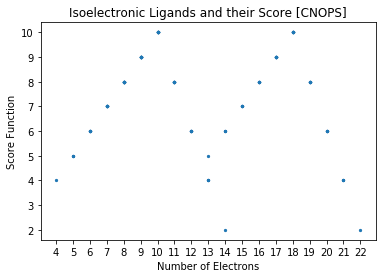

In [41]:
# plot of score function vs number of total electrons. It seems like the number of electrons determines the score fullz.
plt.scatter(isoList, score, s = 5)
plt.xlabel('Number of Electrons')
plt.ylabel('Score Function')
plt.title('Isoelectronic Ligands and their Score ['+ components + "]")
plt.xticks(np.unique(isoList))
# plt.savefig('score_iso_ligands_' + components + ".pdf", bbox_inches='tight')
plt.show()


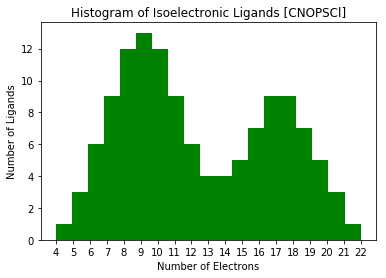

In [73]:
# plot the number of ligands sorted by the number of electrons (isoelectronic structures)

numBins = len(np.unique(isoList))

plt.hist(isoList, bins = numBins, facecolor='green')
plt.xlabel('Number of Electrons')
plt.ylabel('Number of Ligands')
plt.title('Histogram of Isoelectronic Ligands ['+ components + "]")
plt.xticks(np.unique(isoList))
# plt.savefig('hist_iso_ligands_' + components + ".pdf", bbox_inches='tight')
plt.show()


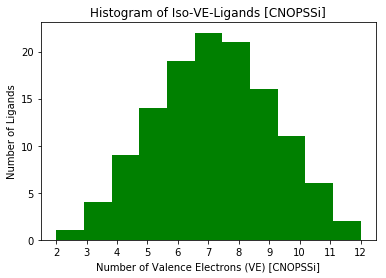

In [78]:
# plot the number of ligands sorted by the number of VE (VE-isoelectronic structures)

numBins = len(np.unique(veList))

plt.hist(veList, bins = numBins, facecolor='green')
plt.xlabel('Number of Valence Electrons (VE) ['+ components + "]")
plt.ylabel('Number of Ligands')
plt.title('Histogram of Iso-VE-Ligands ['+ components + "]")
plt.xticks(np.unique(veList))
# plt.savefig('hist_isove_ligands_' + components + ".pdf", bbox_inches='tight')
plt.show()
